# 아웃포커싱(Out-focusing) 구현하기

이 노트북에서는 torchvision의 DeepLabV3 모델을 사용하여 이미지에서 사람을 인식하고, 배경을 블러 처리하는 아웃포커싱 기능을 구현합니다.

In [41]:
import os
import urllib.request
import cv2
import numpy as np
import torch
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt

print(f"import done")

import done


## 1. PascalVOC 데이터셋의 클래스 이름 정의

In [42]:
# PascalVOC 데이터셋의 클래스 이름
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

print(f"Counts of Class: {len(LABEL_NAMES)}")
print(f"'사람' 클래스 인덱스: {LABEL_NAMES.index('person')}")
print(f"'고양이' 클래스 인덱스: {LABEL_NAMES.index('cat')}")
print(f"'강아지' 클래스 인덱스: {LABEL_NAMES.index('dog')}")

CAT_INDEX = LABEL_NAMES.index('cat')
PERSON_INDEX = LABEL_NAMES.index('person')
PUPPY_INDEX = LABEL_NAMES.index('dog')

Counts of Class: 21
'사람' 클래스 인덱스: 15
'고양이' 클래스 인덱스: 8
'강아지' 클래스 인덱스: 12


## 2. 장치 설정 및 DeepLabV3 모델 로드

In [43]:
# 사용 가능한 장치 확인
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS 가속 사용 (Apple Silicon)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA 가속 사용")
else:
    device = torch.device("cpu")
    print("CPU 사용")

# DeepLabV3 모델 로드
try:
    model = torchvision.models.segmentation.deeplabv3_resnet101(weights='DEFAULT')
except:
    # 이전 버전 torchvision 호환성
    model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)

model.eval()  # 평가 모드로 설정

# 장치로 모델 이동
if device.type != "cpu":
    model = model.to(device)

MPS 가속 사용 (Apple Silicon)


## 3. 함수 정의

In [44]:
def load_image(img_path, resize=None):
    """이미지를 로드하고 전처리합니다."""
    # 이미지 로드
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 이미지 크기 조절
    if resize is not None:
        img = cv2.resize(img, resize)
    
    # 이미지 전처리
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225]),
    ])
    
    # 원본 이미지와 전처리된 이미지 반환
    img_tensor = transform(img).unsqueeze(0)
    
    # GPU 디바이스로 이동 (가능한 경우)
    if device.type != "cpu":
        img_tensor = img_tensor.to(device)
        
    return img, img_tensor

def segment_image(model, img_tensor):
    """이미지 세그멘테이션을 수행합니다."""
    with torch.no_grad():
        output = model(img_tensor)['out'][0]
    
    # 각 픽셀에 대해 가장 확률이 높은 클래스 선택
    output = output.argmax(0).cpu().numpy()
    return output

def extract_object(segmentation, class_id):
    """세그멘테이션 결과에서 특정 클래스의 마스크를 추출합니다."""
    # 지정된 클래스에 해당하는 마스크 생성
    object_mask = (segmentation == class_id).astype(np.uint8) * 255
    return object_mask

def apply_background_blur(img, mask, blur_strength=(13, 13)):
    """배경에 블러 효과를 적용합니다."""
    # 마스크를 3채널로 변환
    mask_3channel = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    
    # 배경 마스크 생성
    bg_mask = cv2.bitwise_not(mask_3channel)
    
    # 배경 블러 처리
    img_blur = cv2.blur(img, blur_strength)
    
    # 배경에만 블러 적용
    bg_blur = cv2.bitwise_and(img_blur, bg_mask)
    
    # 사람과 블러 처리된 배경 합성
    result = np.where(mask_3channel == 255, img, bg_blur)
    
    return result

def apply_background_replacement(img_orig, mask, background_img_path):
   """배경을 다른 이미지로 대체합니다."""
   # 배경 이미지 로드 및 원본 이미지 크기에 맞게 조정
   background_img = cv2.imread(background_img_path)
   background_img = cv2.cvtColor(background_img, cv2.COLOR_BGR2RGB)
   background_img = cv2.resize(background_img, (img_orig.shape[1], img_orig.shape[0]))
   
   # 마스크를 3채널로 변환
   mask_3channel = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
   
   # 배경 마스크 생성
   bg_mask = cv2.bitwise_not(mask_3channel)
   
   # 배경에만 새 이미지 적용
   bg_replaced = cv2.bitwise_and(background_img, bg_mask)
   
   # 원본 객체와 새 배경 합성
   result = np.where(mask_3channel == 255, img_orig, bg_replaced)
   
   return result


def visualize_image(img, title=None):
    """이미지를 시각화합니다."""
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

print("finished init functions")

finished init functions


## 4. 이미지 경로 설정 및 테스트 이미지 다운로드

In [48]:
# 이미지 경로
img_path = os.path.join('..', 'images', 'cat4.jpg')

# 이미지 파일 존재 확인 및 다운로드
if not os.path.exists(img_path):
    print(f"이미지 파일이 존재하지 않습니다: {img_path}")
    print("테스트 이미지를 다운로드합니다...")
    
    # 이미지 디렉토리 생성
    os.makedirs(os.path.dirname(img_path), exist_ok=True)
    
    # 샘플 이미지 URL (Unsplash에서 무료 이미지)
    sample_img_url = "https://images.unsplash.com/photo-1552058544-f2b08422138a"
    
    # 이미지 다운로드
    urllib.request.urlretrieve(sample_img_url, img_path)
    print(f"테스트 이미지를 다운로드했습니다: {img_path}")
else:
    print(f"이미지 파일이 존재합니다: {img_path}")

이미지 파일이 존재합니다: ../images/cat4.jpg


## 5. 이미지 로드 및 세그멘테이션

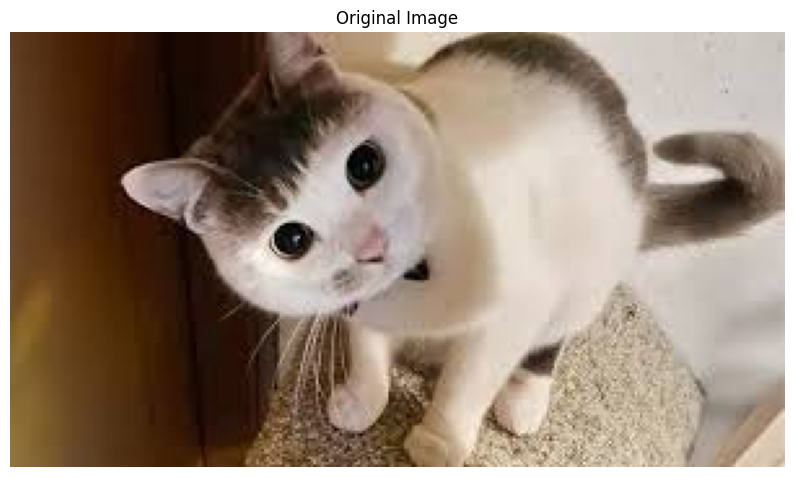

In [49]:
# 이미지 로드 및 전처리
img_orig, img_tensor = load_image(img_path)

# 원본 이미지 시각화
visualize_image(img_orig, 'Original Image')

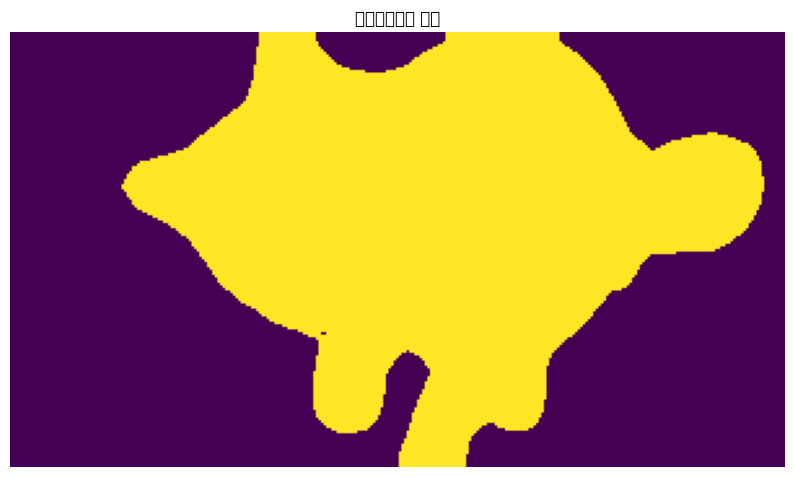

Recognized Class:
  - 0: background
  - 8: cat


In [50]:
# 세그멘테이션 수행
segmentation = segment_image(model, img_tensor)

# 세그멘테이션 결과 시각화
plt.figure(figsize=(10, 8))
plt.imshow(segmentation)
plt.title('세그멘테이션 결과')
plt.axis('off')
plt.show()

# 세그멘테이션에서 인식된 클래스 확인
unique_classes = np.unique(segmentation)
print("Recognized Class:")
for class_id in unique_classes:
    print(f"  - {class_id}: {LABEL_NAMES[class_id]}")

## 6. 타겟 마스크 추출

### 6-1 사람 마스크

사람 고양이 강아지 가 같이 있을 경우 main을 선택해주는 것이 진행하는데 더 수월

In [ ]:
target_class_id = PERSON_INDEX

### 6-2 고양이 마스크

In [51]:
target_class_id = CAT_INDEX

### 6-3 강아지 마스크

In [ ]:
target_class_id = PUPPY_INDEX

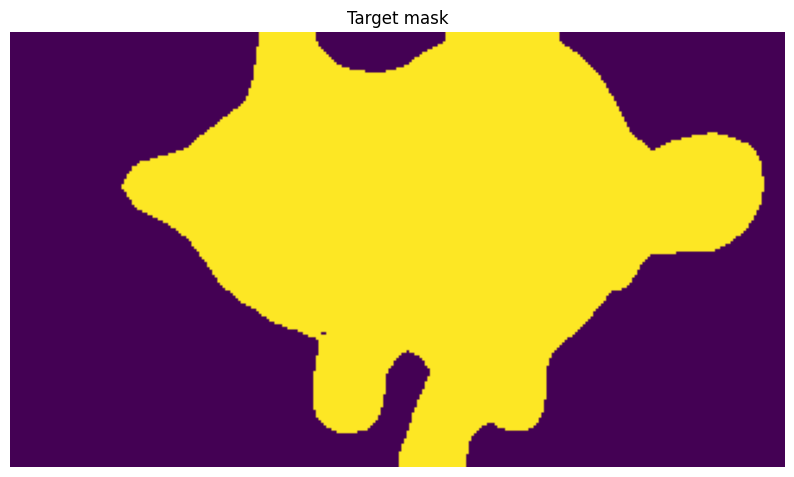

In [52]:
# 타겟 마스크 추출
target_mask = extract_object(segmentation, target_class_id)

# 타겟 마스크 시각화
visualize_image(target_mask, 'Target mask')


## 7. 배경 블러 처리

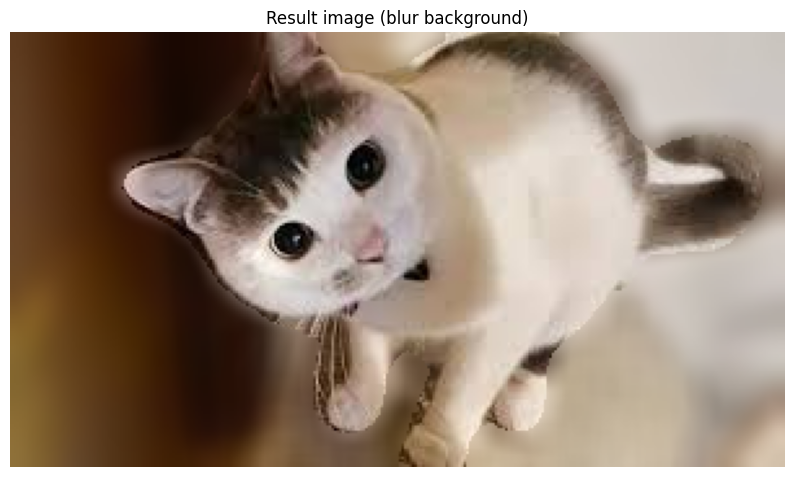

In [53]:
# 배경 블러 처리
result = apply_background_blur(img_orig, target_mask, blur_strength=(13, 13))

# 결과 시각화
visualize_image(result, 'Result image (blur background)')

## 8. 다양한 블러 강도 비교

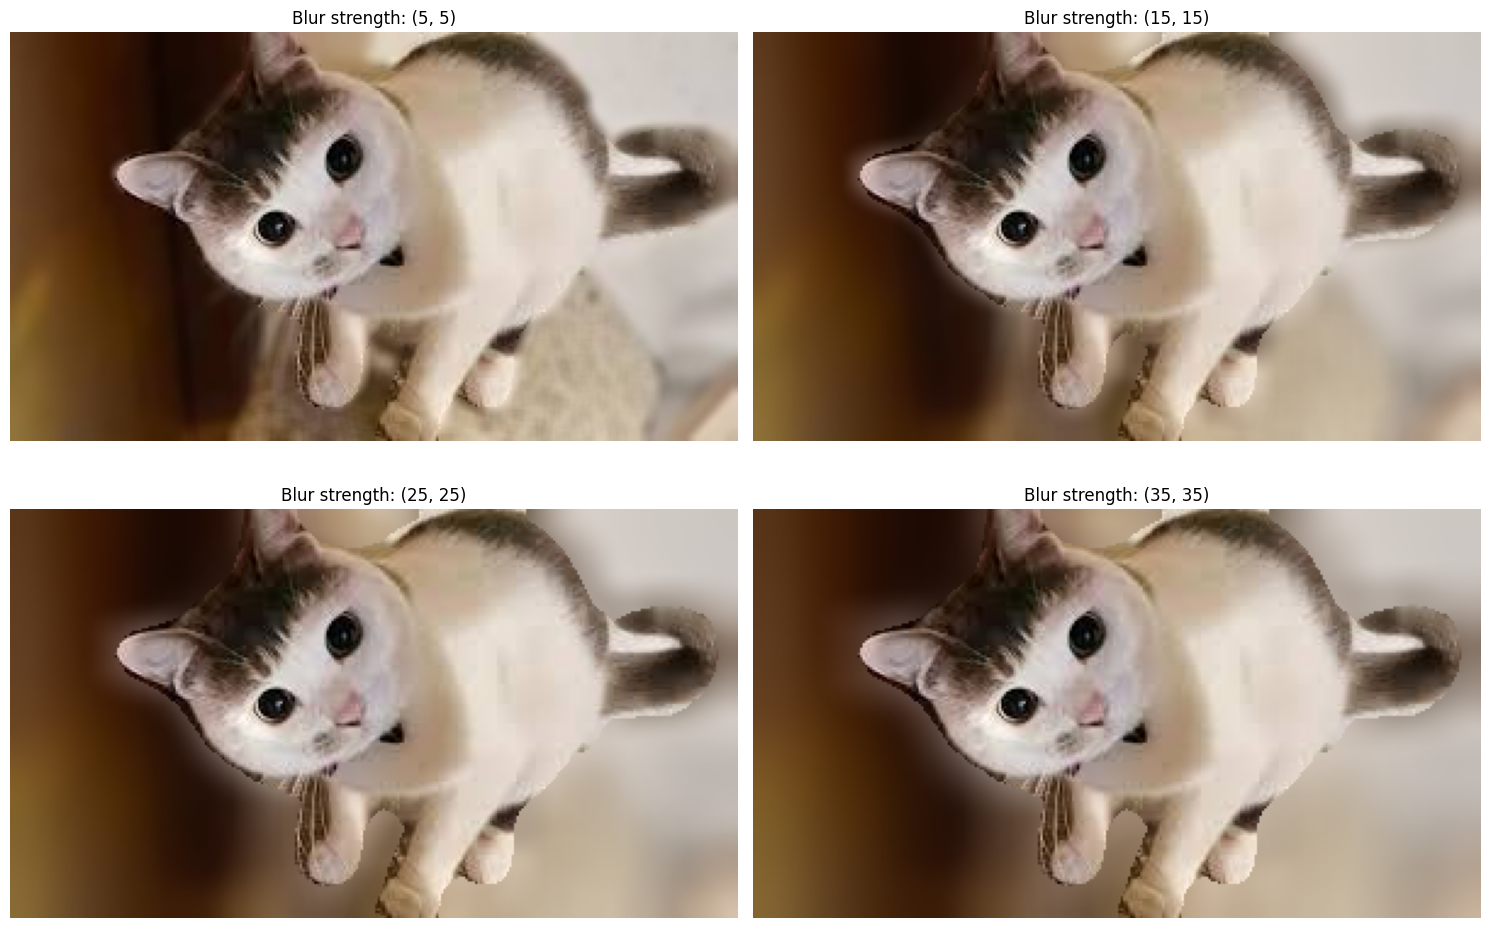

In [54]:
# 다양한 블러 강도 비교
blur_strengths = [(5, 5), (15, 15), (25, 25), (35, 35)]

plt.figure(figsize=(15, 10))
for i, blur_strength in enumerate(blur_strengths):
    result = apply_background_blur(img_orig, target_mask, blur_strength=blur_strength)
    
    plt.subplot(2, 2, i+1)
    plt.imshow(result)
    plt.title(f'Blur strength: {blur_strength}')
    plt.axis('off')

plt.tight_layout()
plt.show()

## 9. 배경 변환

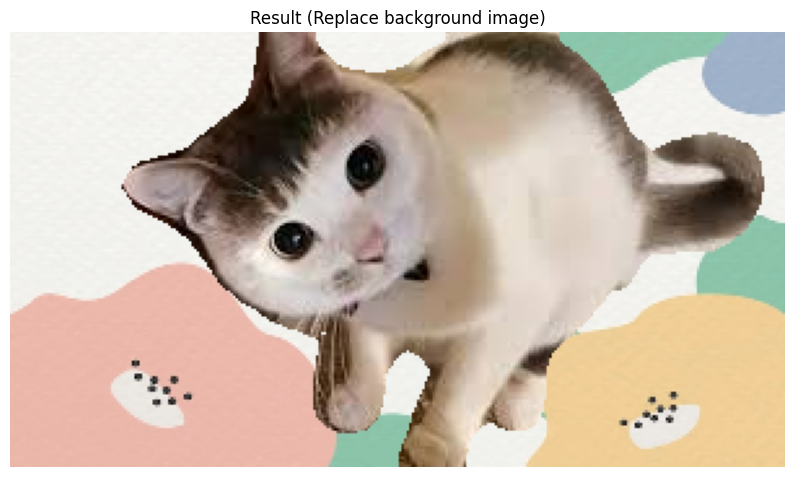

In [56]:

# 배경 변환
img_bg_path = os.path.join('..', 'images','bg', 'bg4.jpg')

result = apply_background_replacement(img_orig, target_mask, img_bg_path)

# 결과 시각화
visualize_image(result, 'Result (Replace background image)')
